### Procedimento Resumido para Seleção dos ZCTAs para Expansão de Laboratórios

Este notebook descreve passo a passo o procedimento adotado para identificar três ZCTAs ideais para a expansão estratégica da rede de laboratórios, seguindo critérios validados por análises anteriores:

1. Identificação das áreas com maior população
    - Selecionar ZCTAs com alta densidade populacional (top 3%), dado que existe correlação significativa entre população e potencial de receita.

2. Exclusão das áreas com renda média-alta (Quartil Q3)
    - Focar nas áreas de baixa renda (Q1), média-baixa renda (Q2) e alta renda (Q4), evitando o Q3 devido ao desempenho inferior comprovado.

3. Aplicação do Indicador de Expansão (expansion_indicator)
    - Calcular e ordenar o indicador específico que prioriza regiões com maior concentração populacional entre 25-54 anos (alta demanda) e menor proporção de crianças (0-5 anos), ponderado pela proporção feminina, garantindo maior retorno potencial.

---

In [7]:
# Importando bibliotecas
import warnings
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [8]:
# Carregando os data sets relacionados
geocode_data = pd.read_csv('../../data/processed/geocode_data_clean.csv')
economic_data = pd.read_csv('../../data/processed/economic_data_clean.csv')
demographic_data = pd.read_csv('../../data/processed/demographic_data_clean.csv')

In [9]:
# 1. Obtendo ZCTAs excluidos de áreas com renda média-alta (Quartil Q3)

# Mapeando faixas de renda para valores numéricos
income_mapping = {
    '< $10.000': 5000,
    '$10.000 - $14.999': 12500,
    '$15.000 - $24.999': 20000,
    '$25.000 - $34.999': 30000,
    '$35.000 - $49.999': 42500,
    '$50.000 - $74.999': 62500,
    '$75.000 - $99.999': 87500,
    '$100.000 - $149.999': 125000,
    '$150.000 - $199.999': 175000,
    '$200.000 >=': 250000 
}

# Adicionando coluna com valor numérico aproximado para cada faixa de renda
economic_data['income_value'] = economic_data['household_range'].map(income_mapping)
weighted_income = economic_data.groupby('zipcode').apply(
    lambda x: sum(x['income_value'] * x['total_households']) / x['total_households'].sum(), include_groups=False
)

weighted_income.head()

zipcode
601    21281.993102
602    26385.792779
603    27007.879135
606    17896.968140
610    28714.042069
dtype: float64

In [10]:
# Transformando em um dataframe
weighted_income_df = weighted_income.reset_index()
weighted_income_df.columns = ['zipcode', 'weighted_avg_income']

# Dividindo em 4 quatis
weighted_income_df['income_quartile'] = pd.qcut(weighted_income_df['weighted_avg_income'], 4, labels=['Q1 (Baixa)', 'Q2 (Média-Baixa)', 'Q3 (Média-Alta)', 'Q4 (Alta)'])

# Excluindo o q3 - média alta
weighted_income_df = weighted_income_df[weighted_income_df['income_quartile'] != 'Q3 (Média-Alta)']
weighted_income_df.head()

,zipcode,weighted_avg_income,income_quartile
0,601,21281.993102,Q1 (Baixa)
1,602,26385.792779,Q1 (Baixa)
2,603,27007.879135,Q1 (Baixa)
3,606,17896.968140,Q1 (Baixa)
4,610,28714.042069,Q1 (Baixa)


In [11]:
# 2. Calculo do Indicador expansion_indicator

# 2.1 - Numerador
# Obter as faixas apenas de interesse
ages_groups_prioritis = ['< 5 Years', '25 - 34 Years', '35 - 44 Years', '45 - 54 Years']
demo_ages_groups_priority = demographic_data[demographic_data['age_group'].isin(ages_groups_prioritis)]

demo_ages_groups_priority.head()

,id,zipcode,total_population,sex_ratiomalesper100females,median_age_in_years,age_group,group_population
0,8600000US35004,35004,12045,94.1,35.5,< 5 Years,805
1,8600000US35005,35005,7344,86.1,44.0,< 5 Years,504
2,8600000US35006,35006,2883,108.2,47.2,< 5 Years,96
3,8600000US35007,35007,26332,95.0,37.7,< 5 Years,1936
4,8600000US35010,35010,20613,90.5,42.6,< 5 Years,1306


In [12]:
# Valor subtraido ao numerador
under_five = demo_ages_groups_priority[demo_ages_groups_priority['age_group'] == '< 5 Years'].copy()

# Valor somado ao numerador
others = demo_ages_groups_priority[demo_ages_groups_priority['age_group'] != '< 5 Years'].copy()

# Agregando os valores por zipcode
zipcode_agregated = demo_ages_groups_priority.groupby('zipcode').agg({
    'total_population': 'first',
    'sex_ratiomalesper100females': 'first',
    'median_age_in_years': 'first'
}).reset_index()

zipcode_agregated.head()

,zipcode,total_population,sex_ratiomalesper100females,median_age_in_years
0,601,17113,99.5,41.9
1,602,37751,96.0,42.9
2,603,47081,96.5,42.1
3,606,6392,100.3,44.3
4,610,26686,93.9,42.7


In [13]:
# Calcular o Numerador
# age_indicator = total_population('25 - 34 Years', '35 - 44 Years', '45 - 54 Years') - total_population('< 5 Years')

# Primeiro soma todos os group_ratio dos outros grupos por zipcode
others_sum = others.groupby('zipcode')['group_population'].sum().reset_index().rename(columns={'group_population': 'others_sum'})

# Depois obtem o group_population do grupo < 5 Years por zipcode
under_five_val = under_five.groupby('zipcode')['group_population'].sum().reset_index().rename(columns={'group_population': 'under_five_val'})

# Juntando ao resultado
age_indicator = pd.merge(pd.merge(zipcode_agregated, others_sum, on='zipcode', how='left'), under_five_val, on='zipcode', how='left')

age_indicator.head()

,zipcode,total_population,sex_ratiomalesper100females,median_age_in_years,others_sum,under_five_val
0,601,17113,99.5,41.9,6427,803
1,602,37751,96.0,42.9,14726,1492
2,603,47081,96.5,42.1,17496,2062
3,606,6392,100.3,44.3,2349,275
4,610,26686,93.9,42.7,10337,1028


In [14]:
# Por fim calculando o age_indicator
age_indicator['age_indicator'] = age_indicator['others_sum'] - age_indicator['under_five_val']

# Removendo as colunas temporárias
age_indicator = age_indicator[['zipcode', 'total_population', 'sex_ratiomalesper100females', 
                'median_age_in_years', 'age_indicator']]

age_indicator.head()

,zipcode,total_population,sex_ratiomalesper100females,median_age_in_years,age_indicator
0,601,17113,99.5,41.9,5624
1,602,37751,96.0,42.9,13234
2,603,47081,96.5,42.1,15434
3,606,6392,100.3,44.3,2074
4,610,26686,93.9,42.7,9309


In [15]:
# Filtrando pelos top 3% zipcodes em população
top_3_population = age_indicator['total_population'] > age_indicator['total_population'].quantile(0.97)
age_indicator_top3 = age_indicator[top_3_population]

age_indicator_top3.head()

,zipcode,total_population,sex_ratiomalesper100females,median_age_in_years,age_indicator
5,612,59369,89.3,42.6,19161
41,693,53360,91.9,41.4,17786
56,725,80537,84.4,41.9,26793
57,727,52743,91.2,40.8,19508
59,729,51015,91.6,40.1,18328


In [16]:
# Adicionando quartil de renda
age_indicator_top3_income = age_indicator_top3.merge(weighted_income_df, on='zipcode', how='left')

age_indicator_top3_income['income_quartile'].value_counts()

income_quartile
Q4 (Alta)           370
Q2 (Média-Baixa)    150
Q1 (Baixa)          117
Q3 (Média-Alta)       0
Name: count, dtype: int64

In [17]:
# Criando funções e constante para normalizar os critérios para o expansion_indicator

min_ai = min(age_indicator['age_indicator'])
max_ai = max(age_indicator['age_indicator'])

min_sr = min(age_indicator['sex_ratiomalesper100females'])
max_sr = max(age_indicator['sex_ratiomalesper100females'])

def normalize(x, min_x, max_x):
    """
    Normaliza os dados entre 0 e 1
    """
    return (x - min_x) / (max_x - min_x)

In [18]:
# Aplicando o indicador normalizado

age_indicator_top3_income.loc[:, 'priority'] = (normalize(age_indicator_top3_income['age_indicator'], min_ai, max_ai) / normalize(age_indicator_top3_income['sex_ratiomalesper100females'], min_sr, max_sr))

In [19]:
# Ordenando pelo indicador, filtrando pelotop 3 e obtendo as colunas de interesse
final_result = age_indicator_top3_income.sort_values(by='priority', ascending=False).head(3)[['zipcode', 'total_population', 'sex_ratiomalesper100females', 'age_indicator', 'income_quartile']]

### **Vizualisando os resultados**

In [20]:
final_result

,zipcode,total_population,sex_ratiomalesper100females,age_indicator,income_quartile
88,11212,75605,71.2,28084,Q1 (Baixa)
105,11236,100844,77.0,34280,Q4 (Alta)
58,10128,58636,75.0,26296,Q4 (Alta)


In [21]:
print('Os ZCTAs escolhidos para expansão foram:')
for zipcode in final_result['zipcode'].unique():
    print(f'- {zipcode}')

Os ZCTAs escolhidos para expansão foram:
- 11212
- 11236
- 10128


#### Vizualizando os valores dos critérios escolhidos em relação ao todo

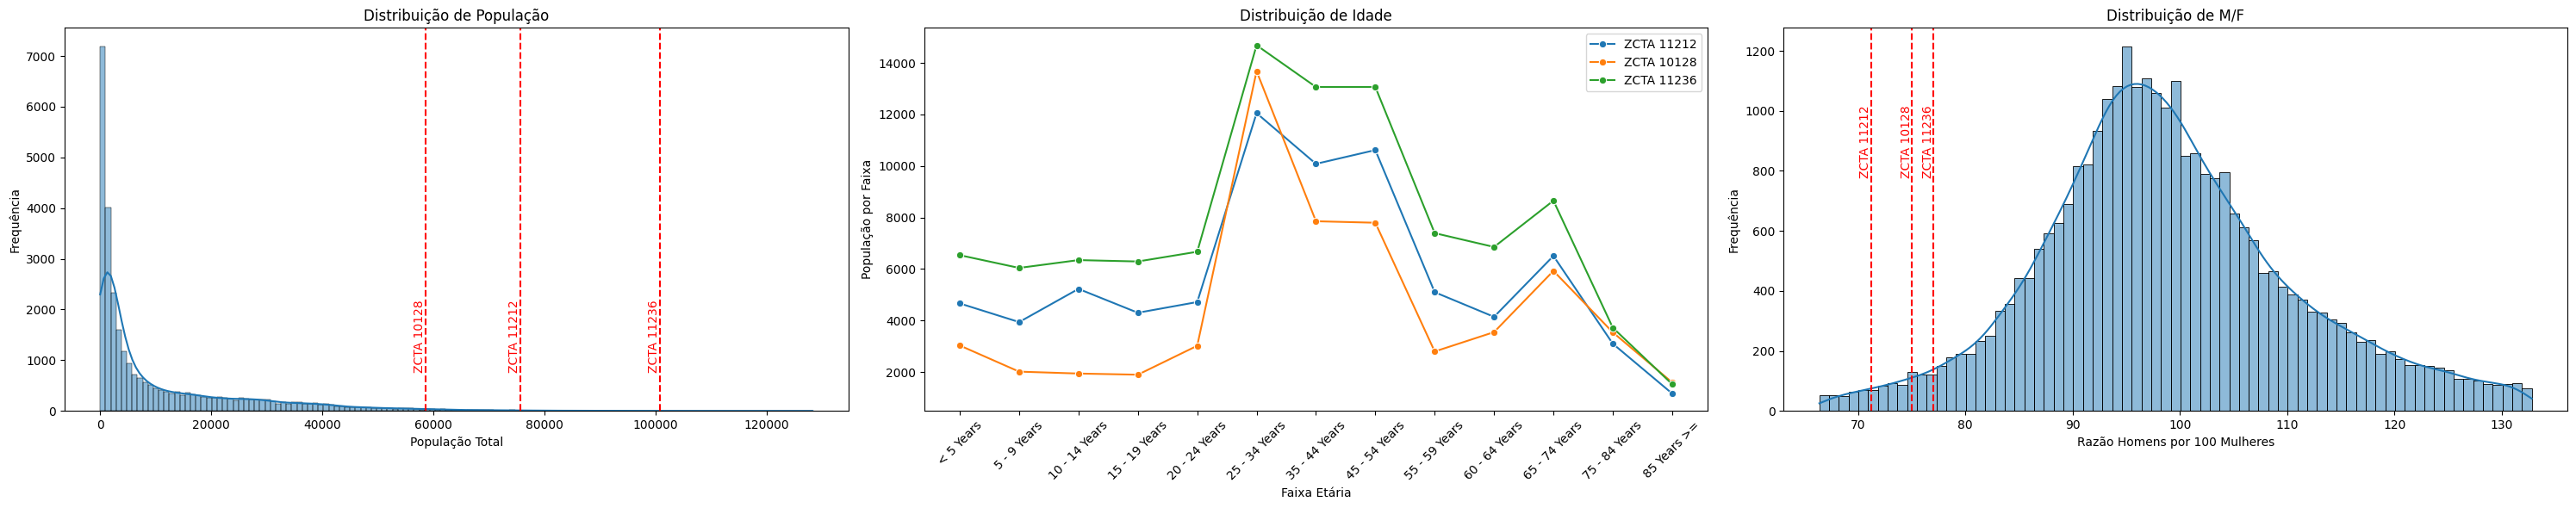

In [22]:

# Obtendo a população por ZCTA
demographic_population = demographic_data.groupby('zipcode').agg({
    'total_population': 'first',
}).reset_index()

# Obtendo o sex_ratiomalesper100females por ZCTA
demographic_female = demographic_data.groupby('zipcode').agg({
    'sex_ratiomalesper100females': 'first',
}).reset_index()

final_zipcodes = [11212, 10128, 11236]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 6))
# 1: Distribuição de População
sns.histplot(
    data=demographic_population,
    x='total_population',
    kde=True,
    ax=axes[0]
)
axes[0].set_title('Distribuição de População')
axes[0].set_xlabel('População Total')
axes[0].set_ylabel('Frequência')

for z in final_zipcodes:
    pop_val = demographic_population.loc[
        demographic_population['zipcode'] == z,
        'total_population'
    ].values[0]
    axes[0].axvline(pop_val, color='red', linestyle='--')
    axes[0].text(
        x=pop_val,
        y=axes[0].get_ylim()[1]*0.1,
        s=f'ZCTA {z}',
        color='red',
        rotation=90,
        ha='right',
        va='bottom'
    )

# 2. Distribuição de Idade
for z in final_zipcodes:
    subset = demographic_data[demographic_data['zipcode'] == z].copy()
    sns.lineplot(
        data=subset,
        x='age_group',
        y='group_population',
        marker='o',
        label=f'ZCTA {z}',
        ax=axes[1]
    )
axes[1].set_title('Distribuição de Idade')
axes[1].set_xlabel('Faixa Etária')
axes[1].set_ylabel('População por Faixa')
axes[1].tick_params(axis='x', rotation=45)

# 3. Distribuição de M/F
sns.histplot(
    data=demographic_female,
    x='sex_ratiomalesper100females',
    kde=True,
    ax=axes[2]
)
axes[2].set_title('Distribuição de M/F')
axes[2].set_xlabel('Razão Homens por 100 Mulheres')
axes[2].set_ylabel('Frequência')



for i, z in enumerate(final_zipcodes):
    ratio_val = demographic_female.loc[
        demographic_female['zipcode'] == z,
        'sex_ratiomalesper100females'
    ].values[0]
    axes[2].axvline(ratio_val, color='red', linestyle='--')
    y_pos = axes[2].get_ylim()[1] - 500
    axes[2].text(
        x=ratio_val - 0.5,
        y=y_pos,
        s=f'ZCTA {z}',
        color='red',
        rotation=90,
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()


---

# Conclusão

Com base nas análises realizadas e representadas nos gráficos fornecidos, os critérios adotados para a seleção dos três ZCTAs ideais **(11212, 11236 e 10128)** mostraram-se bem fundamentados e alinhados à estratégia de expansão da rede de laboratórios.

O primeiro gráfico evidencia claramente a relevância da densidade populacional como critério, com os ZCTAs escolhidos posicionados significativamente acima da média geral, indicando alta probabilidade de gerar um maior volume de exames e receita.

No segundo gráfico, a distribuição etária valida a importância de considerar áreas com grande concentração na faixa etária (25-54 anos), com uma tendência clara de alta demanda por exames diagnósticos nessa faixa específica, especialmente relevante nos ZCTAs escolhidos. O indicador de expansão aplicado reforçou justamente a importância dessa concentração etária, confirmando a metodológica adotada.

O terceiro gráfico valida o critério do gênero, mostrando que os ZCTAs selecionados possuem uma proporção favorável de mulheres em relação aos homens, alinhado à hipótese de que áreas com maior presença feminina são mais promissoras para a frequência e volume de exames.

Contudo, apesar da eficácia demonstrada, é importante reconhecer algumas limitações dessa metodologia. Uma delas é a ausência de uma avaliação detalhada sobre a densidade competitiva atual em cada ZCTA, o que poderia impactar significativamente o sucesso da expansão. Além disso, a análise não contempla variáveis qualitativas como comportamento de consumo, percepção local sobre serviços de saúde ou acessibilidade geográfica.